In [1]:
import numpy as np
import sys
import torch
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
from utils import simplex_content

In [2]:
def create_shape(dim, j):
    assert(j in [0, 1, 2, 3])
    assert(dim in [2, 3])
    assert(j <= dim)
    if dim == 3:
        V = [[1, 1, 1],
             [1, -1, -1],
             [-1, 1, -1],
             [-1, -1, 1]]
        if j == 0:
            E = [[0],
                 [1],
                 [2],
                 [3]]
        elif j == 1:
            E = [[0,1],
                 [0,2],
                 [0,3],
                 [1,2],
                 [1,3],
                 [2,3]]
        elif j == 2:
            E = [[0,1,2],
                 [0,1,3],
                 [0,2,3],
                 [1,2,3]]
        elif j == 3:
            E = [[0,1,2,3]]
    elif dim == 2:
        V = [[.25, .25],
             [.75, .25],
             [.50, .75]]
        if j == 0:
            E = [[0],
                 [1],
                 [2]]
        elif j == 1:
            E = [[0,1],
                 [0,2],
                 [1,2]]
        elif j == 2:
            E = [[0,1,2]]
    V = torch.FloatTensor(V)
    E = torch.LongTensor(E)
    
    # normalize V
    V_bb = torch.max(V, dim=0)[0] - torch.min(V, dim=0)[0]
    V_c = (torch.max(V, dim=0)[0] + torch.min(V, dim=0)[0]) / 2
    V -= V_c
    V /= 1.5*V_bb
    V += 0.5
    return V, E

In [3]:
# random hull
def rand_hull(n_points, dim, dtype=torch.float32):
    V = np.random.rand(n_points, dim)
    mesh = Delaunay(V)
    E = mesh.simplices
    V, E = torch.tensor(V, dtype=dtype), torch.LongTensor(E)
    # normalize V
    V_bb = torch.max(V, dim=0)[0] - torch.min(V, dim=0)[0]
    V_c = (torch.max(V, dim=0)[0] + torch.min(V, dim=0)[0]) / 2
    V -= V_c
    V /= 1.5*V_bb
    V += 0.5
    return V, E

In [4]:
def simplex_content_old(V, E):
    """
    Compute the content of simplices in a simplicial complex
    :param V: vertex tensor. float tensor of shape (n_vertex, n_dims)
    :param E: element tensor. int tensor of shape (n_elem, j+1)
    """
    ne = E.shape[0] # number of elements
    nppe = E.shape[1] # number of points per element
    assert(nppe in [1, 2, 3, 4]) # points, lines, tri or tet
    if nppe == 1: # points
        return torch.ones(ne, 1, dtype=V.dtype)
    if nppe == 2: # lines
        P = V[E]
        Len = torch.norm(P[:, 1:] - P[:, :-1], dim=-1)
        return Len
    elif nppe == 3: # triangles
        E_ = torch.cat([E, E[:, 0:1]], dim=-1)
        P = V[E_]
        L = torch.norm(P[:, 1:] - P[:, :-1], dim=-1)
        S = torch.sum(L, dim=-1, keepdim=True) / 2
        Area = torch.sqrt(S*(S-L[:, 0:1])*(S-L[:, 1:2])*(S-L[:, 2:])) # Heron's Formula
        return Area
    elif nppe == 4: # tetrahedron
        P = V[E]
        Va = P[:, 1] - P[:, 0]
        Vb = P[:, 2] - P[:, 0]
        Vc = P[:, 3] - P[:, 0]
        Vol = torch.abs(torch.einsum('ab,ab->a', (Va, torch.cross(Vb, Vc, dim=-1))) / 6)
        return Vol
        

In [5]:
import torch
import torch.nn as nn
from torch.autograd import Function
from torch.autograd.function import once_differentiable
from math import pi

from utils import fftfreqs, simplex_content, triangulate_interior, permute_seq, coalesce_update
from math import ceil, factorial

class SimplexFT(Function):
    """
    Fourier transform for signal defined on a j-simplex set in R^n space
    :param V: vertex tensor. float tensor of shape (n_vertex, n_dims)
    :param E: element tensor. int tensor of shape (n_elem, j or j+1)
              if j cols, triangulate/tetrahedronize interior first.
    :param D: int ndarray of shape (n_vertex, n_channel)
    :param res: n_dims int tuple of number of frequency modes
    :param t: n_dims tuple of period in each dimension
    :param j: dimension of simplex set
    :param mode: normalization mode.
                 'density' for preserving density, 'mass' for preserving mass
    :return: F: ndarray of shape (res[0], res[1], ..., res[-1]/2, n_channel)
                last dimension is halfed since the signal is assumed to be real
    """
    @staticmethod
    def forward(ctx, V, E, D, res, t, j, elem_batch=100, mode='density'):
        ## boiler-plate
        ctx.mark_non_differentiable(E, D) # mark non-differentiable
        ctx.res = res
        ctx.t = t
        ctx.j = j
        ctx.mode = mode
        ctx.n_dims = V.shape[1]
        ctx.elem_batch = elem_batch
        # compute content array
        C = factorial(j) * simplex_content(V, E) # [n_elem, 1]
        ctx.save_for_backward(V, E, D, C)

        ## compute frequencies F
        n_dims = ctx.n_dims
        assert(n_dims == len(res))  # consistent spacial dimensionality
        assert(E.shape[0] == D.shape[0])  # consistent vertex numbers
        assert(mode in ['density', 'mass'])

        # number of columns in E
        subdim = E.shape[1] == j and n_dims == j
        assert (E.shape[1] == j+1 or subdim)
        if subdim:
            E = triangulate_interior(V, E)
        n_elem = E.shape[0]
        n_vert = V.shape[0]
        n_channel = D.shape[1]

        # frequency tensor
        omega = fftfreqs(res, dtype=V.dtype).to(V.device) # [dim0, dim1, dim2, d]
        omega[tuple([0] * n_dims)] += 1 # will get rid of this

        # normalize frequencies
        for dim in range(n_dims):
            omega[..., dim] *= 2 * pi / t[dim]

        # initialize output F
        F_shape = list(omega.shape)[:-1]
        F_shape += [n_channel, 2]
        F = torch.zeros(*F_shape, dtype=V.dtype, device=V.device) # [dimX, dimY, dimZ, n_chan, 2] 2: real/imag

        # compute element-point tensor
        P = V[E] # [n_elem, j+1, d]

        # loop over element batches
        for idx in range(ceil(n_elem/elem_batch)):
            id_start = idx * elem_batch
            id_end = min((idx+1) * elem_batch, n_elem)
            Xi = P[id_start:id_end] # [elem_batch, j+1, d]
            Di = D[id_start:id_end] # [elem_batch, n_channel]
            Ci = C[id_start:id_end] # [elem_batch, 1]
            CDi = Ci * Di # [elem_batch, n_channel]
            sig = torch.einsum('bjd,...d->bj...', (Xi, omega)) 
            sig = torch.unsqueeze(sig, dim=-1) # [elem_batch, j+1, dimX, dimY, dimZ, 1]
            esig = torch.stack((torch.cos(sig), -torch.sin(sig)), dim=-1) # [elem_batch, j+1, dimX, dimY, dimZ, 1, 2]
            sig = torch.unsqueeze(sig, dim=-1) # [elem_batch, j+1, dimX, dimY, dimZ, 1, 1]
            denom = torch.ones_like(sig) # [elem_batch, j+1, dimX, dimY, dimZ, 1, 1]
            for dim in range(1, j+1):
                seq = permute_seq(dim, j+1)
                denom *= sig - sig[:, seq]
            tmp = torch.sum(esig / denom, dim=1) # [elem_batch, dimX, dimY, dimZ, 1, 2]
            CDi.unsqueeze_(-1) # [elem_batch, n_channel, 1]
            for _ in range(n_dims): # unsqueeze to broadcast
                CDi.unsqueeze_(dim=1) # [elem_batch, 1, 1, 1, n_channel, 1]
            tmp *= CDi # [elem_batch, dimX, dimY, dimZ, n_channel, 2]
            Fi = torch.sum(tmp, dim=0, keepdim=False) # [dimX, dimY, dimZ, n_channel, 2]
            Fi[tuple([0] * n_dims)] = - 1 / factorial(j) * torch.sum(CDi, dim=0).unsqueeze(dim=-1)
#             Fi *= factorial(j)
            # Fi *= 1j**j # [dimX, dimY, dimZ, n_chan, 2] 2: real/imag
            F += Fi
        if j == 0:
            pass
        elif j == 1:
            F = F[..., [1, 0]]
            F[..., 0] = -F[..., 0]
        elif j == 2:
            F *= -1
        elif j == 3:
            F = F[..., [1, 0]]
            F[..., 1] = -F[..., 1]

        if mode == 'density':
            if not np.array_equal(res, res[0]*np.ones(len(res))):
                print("WARNING: density preserving mode not correctly implemented if not all res are equal")
            F *= res[0] ** j
        return F

    @staticmethod
    @once_differentiable
    def backward(ctx, dF):
        """
        :param dF: per-frequency sensitivity from downstream layers of shape [dimX, dimY, dimZ, n_channel, 2]
        """
        if ctx.needs_input_grad[0]:
            V, E, D, C = ctx.saved_tensors

            n_dims = V.shape[1]
            assert(n_dims == 2) # backwards not implemented for other dims yet
            assert(ctx.j == 2) # not yet implemented for other simplices

            n_elem = E.shape[0]
            n_vert = V.shape[0]
            n_channel = D.shape[1]

            # recover context
            res = ctx.res
            t = ctx.t
            j = ctx.j
            mode = ctx.mode
            n_dims = ctx.n_dims
            elem_batch = ctx.elem_batch

            # frequency tensor
            omega = fftfreqs(res, dtype=V.dtype).to(V.device) # [dim0, dim1, dim2, d]
            omega[tuple([0] * n_dims)] += 1 # will get rid of this

            # normalize frequencies
            for dim in range(n_dims):
                omega[..., dim] *= 2 * pi / t[dim]

            # compute element-point tensor
            P = V[E] # [n_elem, j+1, d]

            # initialize output dV
            dV = torch.zeros_like(V) # [j+1, n_dims]

            # compute element-point tensor
            P = V[E] # [n_elem, j+1, d]

            # helper functions
            seq = lambda i : permute_seq(i, j+1) # return looped sequences
            def img(x): # imaginary of tensor (assume last dim: real/imag)
                res = x[..., [1, 0]]
                res[..., 1] = -res[..., 1]
                return res

            # loop over element batches
            for idx in range(ceil(n_elem/elem_batch)):
                id_start = idx * elem_batch
                id_end = min((idx+1) * elem_batch, n_elem)
                elem_batch_i = id_end - id_start
                Xi = P[id_start:id_end] # [elem_batch, j+1, d]
                Di = D[id_start:id_end] # [elem_batch, n_channel]
                Ci = C[id_start:id_end] # [elem_batch, 1]
                Ei = E[id_start:id_end] # [elem_batch, j+1]
                CDi = Ci * Di # [elem_batch, n_channel]
                sig = torch.einsum('bjd,...d->bj...', (Xi, omega)) 
                sig = torch.unsqueeze(sig, dim=-1) # [elem_batch, j+1, dimX, dimY, dimZ, 1]
                esig = torch.stack((torch.cos(sig), -torch.sin(sig)), dim=-1) # [elem_batch, j+1, dimX, dimY, dimZ, 1, 2]
                # specific code for j == 2 and dim == 2 TODO: Add other dimensions
                s01 = 1/(sig - sig[:, seq(1)]).unsqueeze(-1)
                s20 = 1/(sig[:, seq(2)] - sig).unsqueeze(-1)
                tmp = esig * s01 * s20 # [elem_batch, j+1, dimX, dimY, dimZ, 1, 2]
                S = torch.sum(tmp, dim=1, keepdim=True) # [elem_batch, 1, dimX, dimY, dimZ, 1, 2]
                tmp = img(tmp) + tmp*(s01 - s20) + tmp[:, seq(1)]*s01 - tmp[:, seq(2)]*s20 # [elem_batch, j+1, dimX, dimY, dimZ, 1, 2]
                tmp.unsqueeze_(-3) # [elem_batch, j+1, dimX, dimY, dimZ, 1(n_dims), 1(n_channel), 2(real/imag)]
                tmp = tmp * dF.unsqueeze(-3) # [elem_batch, j+1, dimX, dimY, dimZ, n_dims, n_channel, 2]
                tmp = tmp.view(elem_batch_i, j+1, -1, n_dims, n_channel, 2).sum(2).sum(-1) # [elem_batch, j+1, n_dims, n_channel, 2]
                tmp = -(tmp * CDi.unsqueeze(1).unsqueeze(1).unsqueeze(-1)).view(elem_batch_i, j+1, n_dims, -1).sum(-1) # [elem_batch, j+1, n_dims]
                xy = torch.stack((Xi[:, seq(1), 1] - Xi[:, seq(2), 1], - Xi[:, seq(1), 0] + Xi[:, seq(2), 0]), dim=-1) # [elem_batch, j+1, n_dims]
                tmp2 = S * dF # [elem_batch, 1, dimX, dimY, dimZ, n_channel, 2]
                tmp2 = tmp2.sum(-1).view(elem_batch_i, -1, n_channel).sum(1) # [elem_batch, n_channel]
                tmp2 = -((tmp2 * Di).sum(-1).unsqueeze(-1).unsqueeze(-1) * xy) # [elem_batch, j+1, n_dims]
                ddV = coalesce_update(Ei, tmp + tmp2, dV.shape)
                dV += ddV
                if mode == "density":
                    dV *= res[0] ** j
        else:
            dV = None
            
        return dV, None, None, None, None, None, None, None

    
class DDSL(nn.Module):
    def __init__(self, res, t, j, elem_batch=100, mode='density'):
        super(DDSL, self).__init__()
        self.res = res
        self.t = t
        self.j = j
        self.elem_batch = elem_batch
        self.mode = mode
    def forward(self, V, E, D):
        return SimplexFT.apply(V,E,D,self.res,self.t,self.j,self.elem_batch,self.mode)
        

In [7]:
dim = 2
j = 2
npoints = 30
r = 1024

# V, E = create_shape(dim=dim,j=j)
V, E = rand_hull(npoints, dim, dtype=torch.float64)
V += 1e-3 * torch.rand(V.shape, dtype=V.dtype, device=V.device)
# D = torch.ones(E.shape[0], 1, dtype=V.dtype)
D = torch.rand(E.shape[0], 1, dtype=V.dtype)
V.requires_grad = False

res = [r] * dim
t = [1] * dim

V, E, D = V.cuda(), E.cuda(), D.cuda()

ddsl = DDSL(res, t, j, 10, "density")
from time import time
t0 = time()
F = ddsl(V, E, D)
print("Time Lapse: {}".format(time() - t0))
torch.cuda.empty_cache()

Time Lapse: 0.09717726707458496


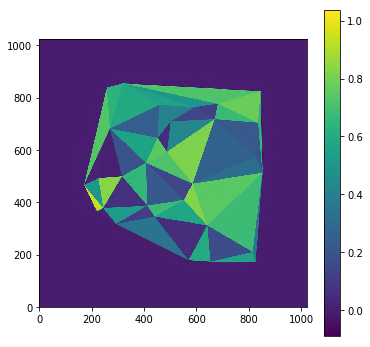

In [11]:
F = F.squeeze()
if torch.sum(torch.isnan(F)) > 0:
    nnan = torch.sum(torch.isnan(F))
    F[torch.isnan(F)] = 0
    print("Padding {} nan terms to zero.".format(nnan))

F_ = F.cpu().detach().numpy()
f_ = torch.irfft(F, dim, signal_sizes=res).squeeze().cpu().detach().numpy()
plt.figure(figsize=(6,6))
# plt.imshow(f_[:, 32, :])
plt.imshow(f_.T, origin='lower')

# plt.imshow(np.fft.ifftshift(F_[:, :, 16, 0], [0,1]))
plt.colorbar()
plt.show()

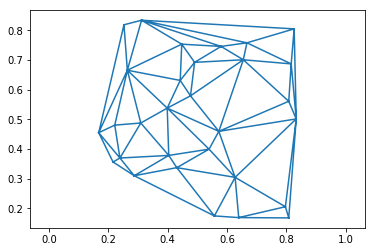

In [9]:
points = V.cpu().numpy()
simplices = E.cpu().numpy()
plt.triplot(points[:,0], points[:,1], simplices.copy())
plt.axis('equal')
plt.show()